In [1]:
from utils.torch_utils import *
from utils.finance_utils import get_financial_data
import matplotlib.pyplot as plt
import torch

# Load financial data

In [2]:
df = get_financial_data()
df.head()

d:\Grgo\Faks\SequentialComparison-TVZ\utils\finance_utils.py:64: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='max') # Download data
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Daily Return,Lagged Return,Log Return,SMA 14,ATR 14
Date,,,,,,,,,,
2015-01-02,24.261045,24.729268,23.821670,24.718172,212818400,-0.018494,-0.019019,-0.009558,24.666027,0.555242
2015-01-05,23.577570,24.110146,23.391169,24.030260,257142000,-0.018838,-0.009513,-0.028576,24.610866,0.581078
2015-01-06,23.579788,23.839418,23.218079,23.641922,263188400,-0.002628,-0.028172,0.000094,24.579641,0.542245
2015-01-07,23.910433,24.010290,23.677430,23.788384,160423600,0.005131,0.000094,0.013925,24.595491,0.511178
2015-01-08,24.829121,24.886817,24.121238,24.238850,237458000,0.024352,0.014022,0.037702,24.634800,0.531941


# Extract unseen data for models

In [3]:
test_data_start = '2023-07-31'
X = df[df.index >= test_data_start]
X.head()

Price,Close,High,Low,Open,Volume,Daily Return,Lagged Return,Log Return,SMA 14,ATR 14
Date,,,,,,,,,,
2023-07-31,194.282089,194.321656,193.105219,193.896394,38824100,0.001989,0.013508,0.003161,191.100453,2.944997
2023-08-01,193.451355,194.558990,193.124995,194.074407,35175100,-0.003210,0.003166,-0.004285,191.512993,2.791708
2023-08-02,190.454803,193.026102,189.732864,192.887648,50389300,-0.012613,-0.004276,-0.015611,191.657101,2.957006
2023-08-03,189.060349,190.247103,188.585650,189.455943,61235200,-0.002088,-0.015490,-0.007349,191.691010,2.981025
2023-08-04,179.981659,185.312177,179.912424,183.472702,115956800,-0.019028,-0.007322,-0.049211,190.843325,3.378022


# Preprocess data

In [4]:
scaler = joblib.load('scalers/standard_scaler.save')
X_scaled = scaler.transform(X.to_numpy())
sequence_length = 10
X_seq, y_seq = create_sequence(X_scaled, input_seq_len=sequence_length, target_seq_len=1)
print(X_seq.shape, y_seq.shape)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_seq, y_seq = to_tensor_to_device((X_seq, y_seq), device)

(527, 10, 10) (527, 10)


# Load models

In [5]:
lstm = load_lstm_model()
gru = load_gru_model()
transformer = load_transformer_model()

d:\Grgo\Faks\SequentialComparison-TVZ\utils\torch_utils.py:268: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load("models/lstm_m2o_20-09-20

# LSTM simulation

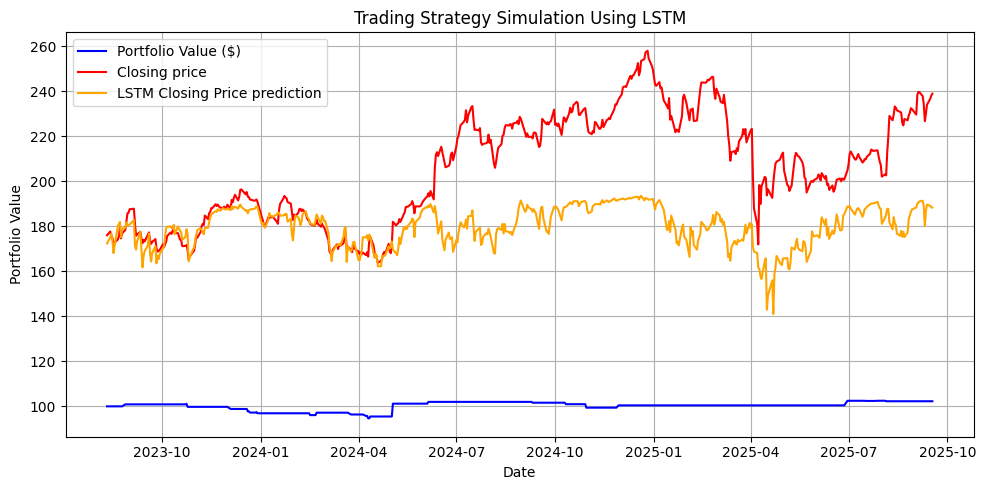

In [6]:
start_index = sequence_length - 1
dates = X.index[start_index : start_index + len(y_seq)]
true_close = X['Close'].iloc[start_index : start_index + len(y_seq)].to_numpy()

capital = 100.0
position = 0.0 
portfolio_values = []

lstm.eval()
predictions = lstm(X_seq).cpu().detach().numpy()
predictions = scaler.inverse_transform(predictions)

for day in range(len(predictions)):
    daily_return = predictions[day, -5]
    lagged_return = predictions[day, -4]
    log_return = predictions[day, -3]
    sma_14 = predictions[day, -2]
    atr_14 = predictions[day, -1]
    current_price = X.iloc[start_index+day]['Close']

    # --- Buy Conditions ---
    if (
        lagged_return > 0 and
        log_return > 0 and
        daily_return > 0 and
        atr_14 < 0.02 * sma_14 and
        position == 0
    ):
        position = capital / current_price
        capital = 0

    # --- Sell Conditions ---
    elif (
        lagged_return < 0 or
        daily_return < 0 or
        atr_14 > 0.03 * sma_14
    ):
        if position > 0:
            capital = position * current_price
            position = 0

    # --- Portfolio Value Update ---
    current_value = capital + position * current_price
    portfolio_values.append(current_value)

plt.figure(figsize=(10, 5))
plt.plot(dates, portfolio_values, label='Portfolio Value ($)', color='blue')
plt.plot(dates, true_close, label="Closing price", color="red")
plt.plot(dates, predictions[:, 0], label="LSTM Closing Price prediction", color="orange")
plt.title('Trading Strategy Simulation Using LSTM')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# GRU Simulation

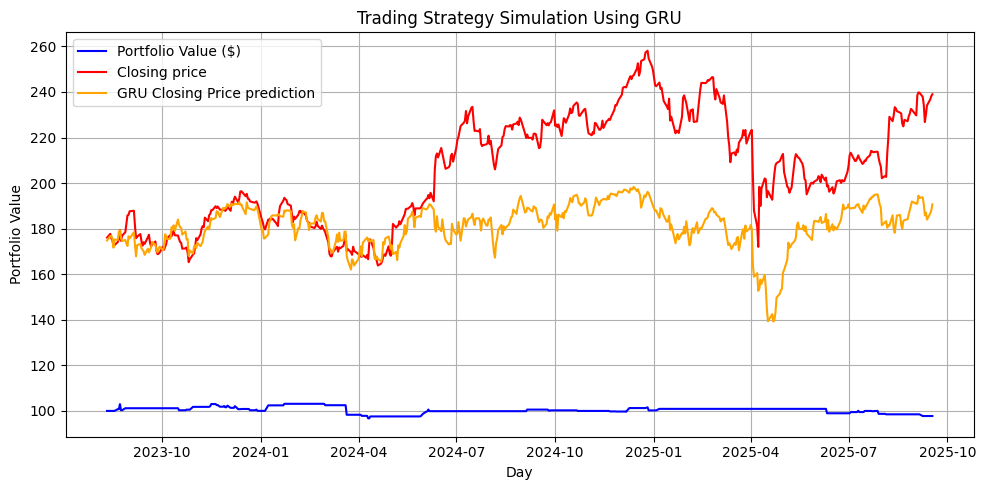

In [7]:
capital = 100.0
position = 0.0 
portfolio_values = []

gru.eval()
predictions = gru(X_seq).cpu().detach().numpy()
predictions = scaler.inverse_transform(predictions)

for day in range(len(predictions)):
    daily_return = predictions[day, -5]
    lagged_return = predictions[day, -4]
    log_return = predictions[day, -3]
    sma_14 = predictions[day, -2]
    atr_14 = predictions[day, -1]
    current_price = X.iloc[start_index+day]['Close']

    # --- Buy Conditions ---
    if (
        lagged_return > 0 and
        log_return > 0 and
        daily_return > 0 and
        atr_14 < 0.02 * sma_14 and
        position == 0
    ):
        position = capital / current_price
        capital = 0

    # --- Sell Conditions ---
    elif (
        lagged_return < 0 or
        daily_return < 0 or
        atr_14 > 0.03 * sma_14
    ):
        if position > 0:
            capital = position * current_price
            position = 0

    # --- Portfolio Value Update ---
    current_value = capital + position * current_price
    portfolio_values.append(current_value)

plt.figure(figsize=(10, 5))
plt.plot(dates, portfolio_values, label='Portfolio Value ($)', color='blue')
plt.plot(dates, true_close, label="Closing price", color="red")
plt.plot(dates, predictions[:, 0], label="GRU Closing Price prediction", color="orange")
plt.title('Trading Strategy Simulation Using GRU')
plt.xlabel('Day')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Transformer Simulation

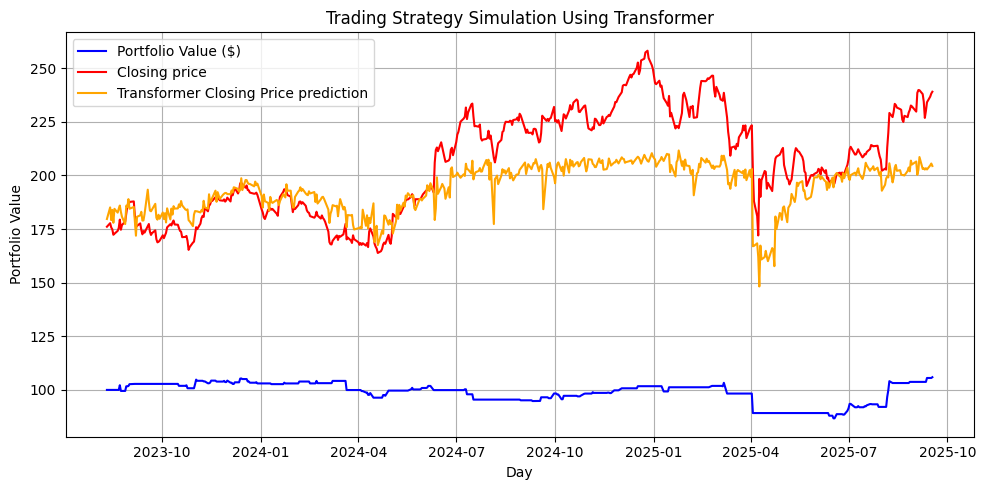

In [8]:
capital = 100.0
position = 0.0 
portfolio_values = []

transformer.eval()
predictions = transformer(X_seq).cpu().detach().numpy()
predictions = scaler.inverse_transform(predictions)

for day in range(len(predictions)):
    daily_return = predictions[day, -5]
    lagged_return = predictions[day, -4]
    log_return = predictions[day, -3]
    sma_14 = predictions[day, -2]
    atr_14 = predictions[day, -1]
    current_price = X.iloc[start_index+day]['Close']

    # --- Buy Conditions ---
    if (
        lagged_return > 0 and
        log_return > 0 and
        daily_return > 0 and
        atr_14 < 0.02 * sma_14 and
        position == 0
    ):
        position = capital / current_price
        capital = 0

    # --- Sell Conditions ---
    elif (
        lagged_return < 0 or
        daily_return < 0 or
        atr_14 > 0.03 * sma_14
    ):
        if position > 0:
            capital = position * current_price
            position = 0

    # --- Portfolio Value Update ---
    current_value = capital + position * current_price
    portfolio_values.append(current_value)

plt.figure(figsize=(10, 5))
plt.plot(dates, portfolio_values, label='Portfolio Value ($)', color='blue')
plt.plot(dates, true_close, label="Closing price", color="red")
plt.plot(dates, predictions[:, 0], label="Transformer Closing Price prediction", color="orange")
plt.title('Trading Strategy Simulation Using Transformer')
plt.xlabel('Day')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()